# Save datasets to Zarr format

This notebook reads in all relevant Sentinel-2 patches, environmental patches and observations (KDE or unmodified) and saves them to .zarr files on S3 buckets

In [1]:
import warnings
import time
import os


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
# from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas as gpd
import dask_geopandas
# from dask.distributed import Client
# from dask_gateway import GatewayCluster

import pystac_client
import planetary_computer as pc
from dask.distributed import Client, progress
import rioxarray

import sys
import os
current_folder = os.getcwd()
sys.path.insert(0, current_folder+'/raster')
sys.path.insert(0, current_folder+'/models')



In [2]:
#Set switch to toggle b/w local and kubernetes cluster
LOCAL = False
# LOCAL = True

In [13]:
def create_centroids_gdf(gdf):
    #Convert to equal area projection and back to avoid CRS issues with calculating centroid:
    c = kde_gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)

    centroids = pd.DataFrame()
    centroids['grid_id'] = gdf.grid_id
    centroids['lon'] = c.x.values
    centroids['lat'] = c.y.values
    centroids = gpd.GeoDataFrame(centroids, geometry=gpd.points_from_xy(centroids['lon'], centroids['lat']))
    
    return centroids

def create_centroids_val_gdf(gdf):
    columns_to_keep = ['latitude','longitude','geometry']
    centroids_val = gdf[columns_to_keep].copy()
    #rename columns
    centroids_val.rename(columns = {'latitude':'lat', 'longitude':'lon'}, inplace = True)
    
    return centroids_val


def _query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull) #TODO replace with rectangular geometry

    search_start = "2019-01-01"
    search_end = "2019-12-31"
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                        modifier=pc.sign_inplace)
    # catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=intersects,
        datetime=[search_start, search_end],
        query={"eo:cloud_cover": {"lt": 10}},
        limit=500,
    )
    ic = search.get_all_items_as_dict()

    features = ic["features"]
    features_d = {item["id"]: item for item in features}

    data = {
        "eo:cloud_cover": [],
        "geometry": [],
    }

    index = []

    for item in features:
        data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])

    items = gpd.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
        "eo:cloud_cover"
    )
    point_list = points.geometry.tolist()

    point_items = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)

    return points.assign(stac_item=point_items)


dask_geopandas_partitions = 250

def add_sentinel_urls(centroids,mode="train"):
    
    print("Organizing grid centroids according to Hilbert distance...")

    ddf = dask_geopandas.from_geopandas(centroids, npartitions=1)
    
    print("Computing hilbert distance ..")
    hd = ddf.hilbert_distance().compute()
    centroids["hd"] = hd
    centroids = centroids.sort_values("hd")
    dgdf = dask_geopandas.from_geopandas(centroids, npartitions=dask_geopandas_partitions, sort=False)
    print("Setting up Dask..")
    # client, cluster = None
    
    try:
        
        
        if not LOCAL:
            print("Attemping to create a new dask client")
            from dask_gateway import GatewayCluster
            cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
            client = cluster.get_client()
            cluster.adapt(minimum=4, maximum=113)

            print(cluster.dashboard_link)
            print(client)
            
        else:
            print("Attemping to create a new local dask client")
            from dask.distributed import Client, LocalCluster
            import multiprocessing as mp
            import dask
            dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"})
            cluster = LocalCluster()
            client = Client(cluster)
            # cluster.adapt(minimum=1, maximum=mp.cpu_count())
            cluster.scale(mp.cpu_count())
            # print(cluster.dashboard_link)
            print(client)
            

        meta = dgdf._meta.assign(stac_item=[])
        df2 = dgdf.map_partitions(_query, meta=meta).compute()

        
        data = df2.dropna(subset=["stac_item"])
        #Save it as a tuple -> (RGB,NIR)
        data['urls'] = [(item["assets"]["visual"]["href"], item["assets"]["B08"]["href"]) for item in data.stac_item.tolist()]
        data['crs']  = [item["properties"]["proj:epsg"] for item in data.stac_item.tolist()]
        print(data.stac_item[0]["properties"]["proj:epsg"])
        print("{} URLs acquired. Shutting Down Cluster".format(len(data)))
        
        # if not LOCAL:
        cluster.close()
        
        if mode=="train":
            data = data.drop(['hd','stac_item'], axis=1).set_index('grid_id').reset_index(drop=True)
        else:
            data = data.drop(['hd','stac_item'], axis=1).reset_index(drop=True)
        return data
    
    except Exception as e:
        print("Error thrown: ",e)
        cluster.close()
        return None
    

# Read Observations

## KDE

### Needed to match the grid centroids


Only change this if changing the size of grids. This is set to 0.05 degrees

In [5]:
BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/labels'
filename = 'geolifeclef_ca_0.05deg_kde_0.1deg_epanechnikov.zarr'
#s3://datasets-sdm/geoLifeCLEF/labels/geolifeclef_ca_0.05deg_kde_0.1deg_epanechnikov.zarr/
local_kde_read_path = '../data/labels/ca/geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl'
# s3_kde_read_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(local_kde_read_path)

../data/labels/ca/geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl


In [6]:
kde_gdf = pd.read_pickle(local_kde_read_path)
kde_gdf

,geometry,grid_id,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,prob_4927,prob_4930,prob_4382,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,"POLYGON ((-124.36556 40.23088, -124.36556 40.2...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((-124.36556 40.28088, -124.36556 40.3...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((-124.36556 40.33088, -124.36556 40.3...",2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((-124.36556 40.38088, -124.36556 40.4...",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((-124.36556 40.43088, -124.36556 40.4...",4,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17168,"POLYGON ((-114.16556 34.23088, -114.16556 34.2...",17168,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17169,"POLYGON ((-114.16556 34.28088, -114.16556 34.3...",17169,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17170,"POLYGON ((-114.16556 34.33088, -114.16556 34.3...",17170,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17171,"POLYGON ((-114.11556 34.23088, -114.11556 34.2...",17171,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Val observations

In [7]:
val_label_filename = 'ca_val_obs.pkl'
s3_read_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, val_label_filename)
print(s3_read_path)

s3://datasets-sdm/geoLifeCLEF/labels/ca_val_obs.pkl


In [9]:
ca_val_gdf = pd.read_pickle(s3_read_path)
ca_val_gdf.head()

,observation_id,latitude,longitude,species_id,geometry,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,20000282,41.523970,-124.045616,2560,POINT (-124.04562 41.52397),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20001056,38.354510,-122.514270,5205,POINT (-122.51427 38.35451),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20001135,38.807053,-122.369255,5243,POINT (-122.36925 38.80705),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20002394,34.023647,-118.417330,5544,POINT (-118.41733 34.02365),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20003318,35.178210,-120.745760,5109,POINT (-120.74576 35.17821),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
assert(ca_val_gdf.prob_5309.sum() == 13.) #Should be 13.0

# Centroids

## Generate a list of centroids for every grid_id [KDE]

In [82]:
centroids = create_centroids_gdf(kde_gdf)
centroids.head()

,grid_id,lon,lat,geometry
0,0,-124.390558,40.255879,POINT (-124.39056 40.25588)
1,1,-124.390558,40.305879,POINT (-124.39056 40.30588)
2,2,-124.390558,40.355879,POINT (-124.39056 40.35588)
3,3,-124.390558,40.405879,POINT (-124.39056 40.40588)
4,4,-124.390558,40.455879,POINT (-124.39056 40.45588)


## Fetch their URLs for Sentinel-2

In [83]:
LOCAL = False

In [84]:
%%time
centroids = add_sentinel_urls(centroids)

Organizing grid centroids according to Hilbert distance...
Computing hilbert distance ..
Setting up Dask..
Attemping to create a new dask client
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.e10d97a135d1491991f128394174c07c/status
<Client: 'tls://10.244.22.208:8786' processes=0 threads=0, memory=0 B>
32610
17173 URLs acquired. Shutting Down Cluster
CPU times: user 820 ms, sys: 0 ns, total: 820 ms
Wall time: 1min 2s


In [85]:
centroids

,lon,lat,geometry,urls,crs
0,-119.590558,33.25588,POINT (-119.59056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
1,-119.490558,33.20588,POINT (-119.49056 33.20588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
2,-119.440558,33.20588,POINT (-119.44056 33.20588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
3,-119.440558,33.25588,POINT (-119.44056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
4,-119.490558,33.25588,POINT (-119.49056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
...,...,...,...,...,...
17168,-114.590558,32.80588,POINT (-114.59056 32.80588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17169,-114.540558,32.80588,POINT (-114.54056 32.80588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17170,-114.540558,32.85588,POINT (-114.54056 32.85588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17171,-114.490558,32.85588,POINT (-114.49056 32.85588),(https://sentinel2l2a01.blob.core.windows.net/...,32611


In [86]:
centroids.urls[17000]

('https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PS/2019/11/17/S2A_MSIL2A_20191117T182641_N0212_R127_T11SPS_20201003T172221.SAFE/GRANULE/L2A_T11SPS_A023004_20191117T183204/IMG_DATA/R10m/T11SPS_20191117T182641_TCI_10m.tif?st=2022-12-12T16%3A32%3A46Z&se=2022-12-14T00%3A32%3A46Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-13T15%3A03%3A57Z&ske=2022-12-20T15%3A03%3A57Z&sks=b&skv=2021-06-08&sig=V8s/ZlRu6rSMfN8dBhs6tMVhkPC5PDOzOcJyZVT5ErY%3D',
 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PS/2019/11/17/S2A_MSIL2A_20191117T182641_N0212_R127_T11SPS_20201003T172221.SAFE/GRANULE/L2A_T11SPS_A023004_20191117T183204/IMG_DATA/R10m/T11SPS_20191117T182641_B08_10m.tif?st=2022-12-12T16%3A32%3A46Z&se=2022-12-14T00%3A32%3A46Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-13T15%3A03%3A57Z&ske=2022-12-20T15%3A03%3A57Z&sk

## Same for val observations

In [14]:
centroids_val = create_centroids_val_gdf(ca_val_gdf)
centroids_val

,lat,lon,geometry
0,41.523970,-124.045616,POINT (-124.04562 41.52397)
1,38.354510,-122.514270,POINT (-122.51427 38.35451)
2,38.807053,-122.369255,POINT (-122.36925 38.80705)
3,34.023647,-118.417330,POINT (-118.41733 34.02365)
4,35.178210,-120.745760,POINT (-120.74576 35.17821)
...,...,...,...
5020,37.493600,-122.368350,POINT (-122.36835 37.49360)
5021,38.026356,-119.249990,POINT (-119.24999 38.02636)
5022,38.826870,-122.349720,POINT (-122.34972 38.82687)
5023,37.211212,-120.842026,POINT (-120.84203 37.21121)


### Drop some stuff to make it look like the observations data

In [15]:
columns_to_drop = ['latitude','longitude', 'observation_id','species_id','geometry']
ca_val_gdf2 = ca_val_gdf.drop(columns_to_drop, axis=1).astype(np.uint8)
ca_val_gdf2.head()

,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,prob_4927,prob_4930,prob_4382,prob_4937,prob_4941,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fetch URLs for Sentinel-2

In [16]:
%%time
centroids_val2 = add_sentinel_urls(centroids_val, mode="val")


Organizing grid centroids according to Hilbert distance...
Computing hilbert distance ..
Setting up Dask..
Attemping to create a new dask client
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.f38bf915e84a403888692b6cd143a0aa/status
<Client: 'tls://10.244.118.50:8786' processes=0 threads=0, memory=0 B>
32610
5025 URLs acquired. Shutting Down Cluster
CPU times: user 906 ms, sys: 195 ms, total: 1.1 s
Wall time: 48 s


/srv/conda/envs/notebook/lib/python3.10/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [17]:
centroids_val2

,lat,lon,geometry,urls,crs
0,34.535717,-119.79601,POINT (-119.79601 34.53572),(https://sentinel2l2a01.blob.core.windows.net/...,32611
1,34.543713,-119.80254,POINT (-119.80254 34.54371),(https://sentinel2l2a01.blob.core.windows.net/...,32611
2,34.543175,-119.80047,POINT (-119.80047 34.54317),(https://sentinel2l2a01.blob.core.windows.net/...,32611
3,34.541320,-119.79459,POINT (-119.79459 34.54132),(https://sentinel2l2a01.blob.core.windows.net/...,32611
4,34.541367,-119.79134,POINT (-119.79134 34.54137),(https://sentinel2l2a01.blob.core.windows.net/...,32611
...,...,...,...,...,...
5020,32.765675,-115.70594,POINT (-115.70594 32.76568),(https://sentinel2l2a01.blob.core.windows.net/...,32611
5021,32.866245,-115.23540,POINT (-115.23540 32.86624),(https://sentinel2l2a01.blob.core.windows.net/...,32611
5022,32.866530,-115.22657,POINT (-115.22657 32.86653),(https://sentinel2l2a01.blob.core.windows.net/...,32611
5023,32.756300,-114.83733,POINT (-114.83733 32.75630),(https://sentinel2l2a01.blob.core.windows.net/...,32611


In [18]:
centroids_val2.urls[5000]

('https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PT/2019/10/23/S2B_MSIL2A_20191023T182419_N0212_R127_T11SPT_20201004T053409.SAFE/GRANULE/L2A_T11SPT_A013738_20191023T182537/IMG_DATA/R10m/T11SPT_20191023T182419_TCI_10m.tif?st=2022-12-13T01%3A33%3A34Z&se=2022-12-14T09%3A33%3A34Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-14T01%3A11%3A10Z&ske=2022-12-21T01%3A11%3A10Z&sks=b&skv=2021-06-08&sig=bUGM/aysphxRSXAuntOMpzSLHEayYWCK5N560zScJw8%3D',
 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PT/2019/10/23/S2B_MSIL2A_20191023T182419_N0212_R127_T11SPT_20201004T053409.SAFE/GRANULE/L2A_T11SPT_A013738_20191023T182537/IMG_DATA/R10m/T11SPT_20191023T182419_B08_10m.tif?st=2022-12-13T01%3A33%3A34Z&se=2022-12-14T09%3A33%3A34Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-14T01%3A11%3A10Z&ske=2022-12-21T01%3A11%3A10Z&sk

# Setup Dataset

In [87]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/rasters'
s3_raster_path = 's3://{}/{}/'.format(BUCKET_NAME, folder)
print(s3_raster_path)

s3://datasets-sdm/geoLifeCLEF/rasters/


In [20]:
# %autoreload 2
from dataset import Dataset

In [21]:
SIDE_PX = 64
SIDE_LEN_M = 6000 #meters, just over 0.05 degrees

## Training set

In [91]:
train_set = Dataset(raster_root=s3_raster_path, subset="train", centroids=centroids, observations=kde_gdf, side_len_m=SIDE_LEN_M,side_px=SIDE_PX)

Setting up SI Patch Extractor..
Setting up env raster extractor..
Processing Raster file for  bio_1
Processing Raster file for  bio_2
Processing Raster file for  bio_3
Processing Raster file for  bio_4
Processing Raster file for  bio_5
Processing Raster file for  bio_6
Processing Raster file for  bio_7
Processing Raster file for  bio_8
Processing Raster file for  bio_9
Processing Raster file for  bio_10
Processing Raster file for  bio_11
Processing Raster file for  bio_12
Processing Raster file for  bio_13
Processing Raster file for  bio_14
Processing Raster file for  bio_15
Processing Raster file for  bio_16
Processing Raster file for  bio_17
Processing Raster file for  bio_18
Processing Raster file for  bio_19
Processing Raster file for  bdticm
Processing Raster file for  bldfie
Processing Raster file for  cecsol
Processing Raster file for  clyppt
Processing Raster file for  orcdrc
Processing Raster file for  phihox
Processing Raster file for  sltppt
Processing Raster file for  sndpp

### Display datasets

In [92]:
%%time
# (patch, target) = train_set[2708]
(patch, target) = train_set[0]

CPU times: user 527 ms, sys: 0 ns, total: 527 ms
Wall time: 798 ms


In [93]:
patch.dtype, target.dtype, patch.shape, target.shape

(dtype('float64'), dtype('uint8'), (31, 64, 64), (5079,))

In [94]:
target

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

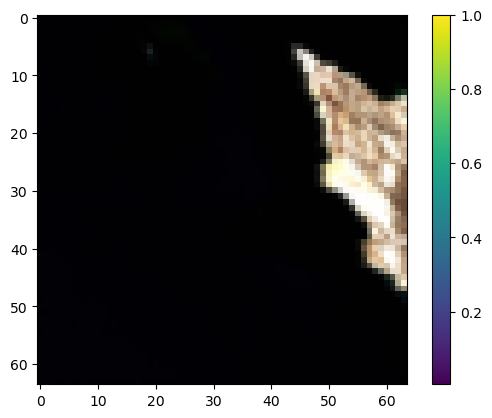

In [95]:
img = patch[0:3,:,:]
# img = img.numpy()
img = img.transpose([1, 2, 0])
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

(0.5736, 0.5736)

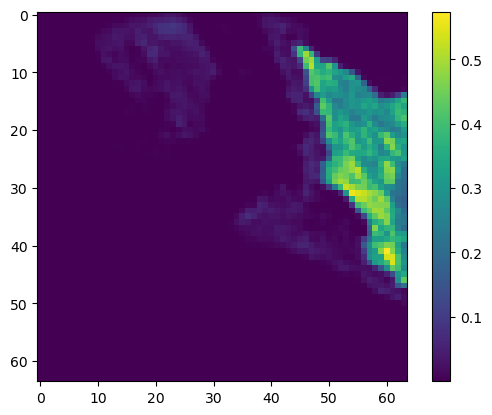

In [96]:
NIR_image = patch[3].squeeze()#-> Remove first dim (channel) 
plt.imshow(NIR_image)#, vmax=1.0)
plt.colorbar()
NIR_image.max(), patch[3].max()

(0.6969696969696972, 0.0)

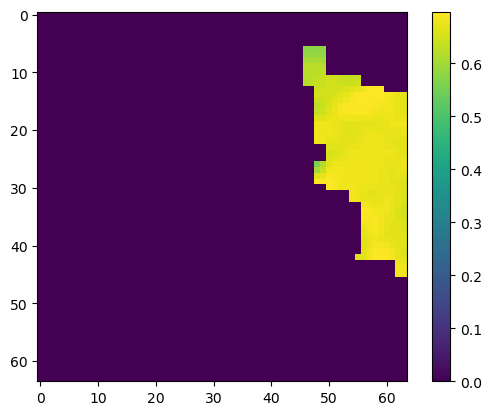

In [97]:
ped = patch[-3].squeeze()#-> Remove first dim (channel) 
plt.imshow(ped)#.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
ped.max(), ped.min()

## Val set

In [22]:
import gc
del centroids_val, ca_val_gdf
gc.collect()

381

In [25]:
val_set = Dataset(raster_root=s3_raster_path, subset="val", centroids=centroids_val2, observations=ca_val_gdf2, side_len_m=SIDE_LEN_M, side_px=SIDE_PX)

Setting up SI Patch Extractor..
Setting up env raster extractor..
Processing Raster file for  bio_1
Processing Raster file for  bio_2
Processing Raster file for  bio_3
Processing Raster file for  bio_4
Processing Raster file for  bio_5
Processing Raster file for  bio_6
Processing Raster file for  bio_7
Processing Raster file for  bio_8
Processing Raster file for  bio_9
Processing Raster file for  bio_10
Processing Raster file for  bio_11
Processing Raster file for  bio_12
Processing Raster file for  bio_13
Processing Raster file for  bio_14
Processing Raster file for  bio_15
Processing Raster file for  bio_16
Processing Raster file for  bio_17
Processing Raster file for  bio_18
Processing Raster file for  bio_19
Processing Raster file for  bdticm
Processing Raster file for  bldfie
Processing Raster file for  cecsol
Processing Raster file for  clyppt
Processing Raster file for  orcdrc
Processing Raster file for  phihox
Processing Raster file for  sltppt
Processing Raster file for  sndpp

### Test patches extracted

In [26]:
%%time
(patch2, target2) = val_set[300]

CPU times: user 915 ms, sys: 74.4 ms, total: 989 ms
Wall time: 11.7 s


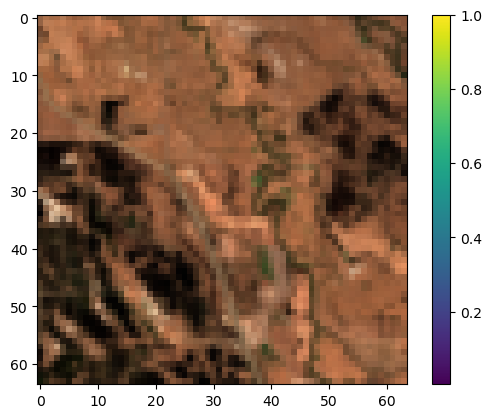

In [27]:
img = patch2[0:3,:,:]
img = img.transpose([1, 2, 0])
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

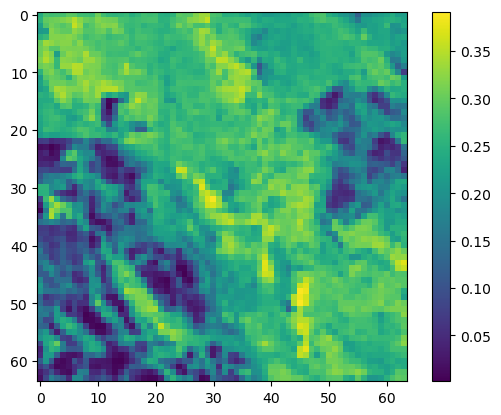

In [28]:
NIR_image = patch2[3].squeeze()#-> Remove first dim (channel) 
plt.imshow(NIR_image)#, vmax=1.0)
plt.colorbar()

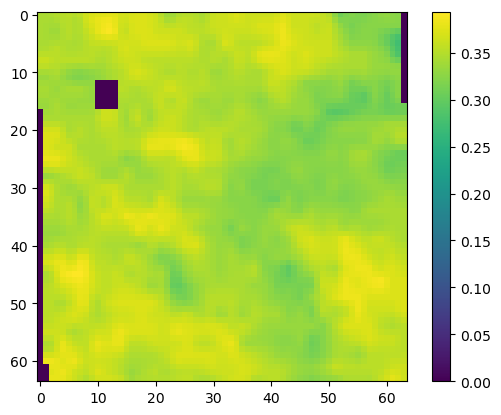

In [29]:
ped = patch2[-1]#-> Remove first dim (channel) 
plt.imshow(ped)#, vmax=1.0)
plt.colorbar()

In [30]:
len(target2), sum(target2)

(5079, 255)

# Dump data to Zarr using a loader

In [37]:
import zarr
import numcodecs

### Create a Zarr dataset with each element consisting of a tuple of patch and target

In [57]:
import warnings
warnings.filterwarnings('ignore')


### Loader testing

In [41]:
BATCH_SIZE = 8
NUM_WORKERS = 4

In [58]:
train_dumper = torch.utils.data.DataLoader(train_set, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [62]:
BUCKET_NAME = 'datasets-sdm'
BUCKET_NAME_L = 'datasets-sdm2'
f_folder = 'geoLifeCLEF/features'
l_folder = 'geoLifeCLEF/labels'

# s3://datasets-sdm2/geoLifeCLEF/features/
f_filename = 'train_ca_{}m_{}px_features'.format(SIDE_LEN_M, SIDE_PX)
l_filename = val_label_filename[0:-5]
s3_feature_path = 's3://{}/{}/{}.zarr'.format(BUCKET_NAME, f_folder, f_filename)
s3_label_path = 's3://{}/{}/{}.zarr'.format(BUCKET_NAME, l_folder, l_filename)
print(s3_feature_path, s3_label_path)
#s3://datasets-sdm2/geoLifeCLEF/labels/

s3://datasets-sdm/geoLifeCLEF/features/train_ca_6000m_64px_features.zarr s3://datasets-sdm/geoLifeCLEF/labels/geolifeclef_ca_0.05deg_kde_0.1deg_epanechnikov.zarr


In [63]:
len(train_set)

17173

In [64]:
train_z_features = zarr.open(s3_feature_path, mode='w', shape=(len(train_set)), \
                    chunks=(1), dtype=object, object_codec=numcodecs.Pickle(),synchronizer=zarr.ThreadSynchronizer())
train_z_labels   = zarr.open(s3_label_path, mode='w', shape=(len(train_set)), \
                    chunks=(1), dtype=object, object_codec=numcodecs.Pickle(),synchronizer=zarr.ThreadSynchronizer())

In [68]:
train_z_features.info

Type,zarr.core.Array
Data type,object
Shape,"(17173,)"
Chunk shape,"(1,)"
Order,C
Read-only,False
Filter [0],Pickle(protocol=5)
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.FSStore
No. bytes,137384 (134.2K)


In [66]:
train_z_labels.info

Type,zarr.core.Array
Data type,object
Shape,"(17173,)"
Chunk shape,"(1,)"
Order,C
Read-only,False
Filter [0],Pickle(protocol=5)
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.FSStore
No. bytes,137384 (134.2K)


In [317]:
# train_z = zarr.open('data/train_ca.zarr', mode='w', shape=(len(train_set),2), \
#                     chunks=(10,None), dtype=object, object_codec=numcodecs.Pickle())

## Save to S3

train_z_labels have already been written into S3 from kde_ca.ipynb

In [ ]:
from tqdm.notebook import tqdm

## Only write features; labels have already been written by kde_ca.ipynb
for i, batch in enumerate(tqdm(train_dumper)):
    
    #Patches and targets together
    for j, p in enumerate(batch[0]):
        if p is not None: #this can happen when it's unable to fetch some SI raster
            train_z_features[j + i*BATCH_SIZE] = p.numpy()
           

  0%|          | 0/2147 [00:00<?, ?it/s]

In [40]:
train_z_features[16][1].dtype, train_z_features[51][0].shape

(dtype('float64'), (64, 64))

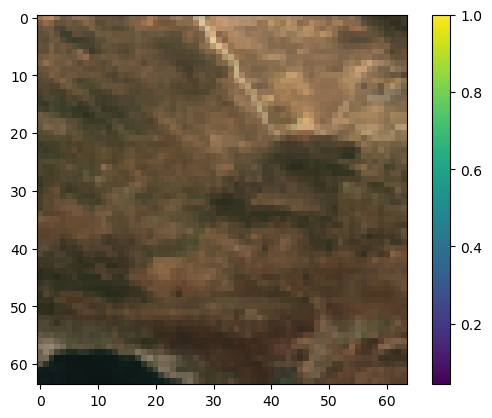

In [42]:
img = train_z_features[121][0:3,:,:]
# img = img.numpy()
img = img.transpose([1, 2, 0])
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

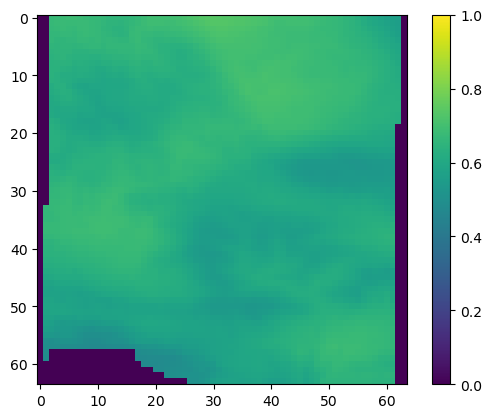

In [43]:
img = train_z_features[121][5,:,:]
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

## Validation set save

In [33]:
f_folder = 'geoLifeCLEF/features'
l_folder = 'geoLifeCLEF/labels'
# s3://datasets-sdm2/geoLifeCLEF/features/

f_filename = 'val_ca_{}m_{}px_features'.format(SIDE_LEN_M, SIDE_PX)
l_filename = val_label_filename[0:-4]

s3_feature_path = 's3://{}/{}/{}.zarr'.format(BUCKET_NAME, f_folder, f_filename)
s3_label_path = 's3://{}/{}/{}.zarr'.format(BUCKET_NAME, l_folder, l_filename)
print(s3_feature_path, s3_label_path)

s3://datasets-sdm/geoLifeCLEF/features/val_ca_6000m_64px_features.zarr s3://datasets-sdm/geoLifeCLEF/labels/ca_val_obs.zarr


In [45]:
BATCH_SIZE = 8
NUM_WORKERS = 8

In [46]:
s3_label_path

's3://datasets-sdm/geoLifeCLEF/labels/ca_val_obs.zarr'

In [52]:
val_z_features = zarr.open(s3_feature_path, mode='w', shape=(len(val_set)), \
                    chunks=(1), dtype=object, object_codec=numcodecs.Pickle(),synchronizer=zarr.ThreadSynchronizer())
val_z_labels   = zarr.open(s3_label_path, mode='w', shape=(len(val_set)), \
                    chunks=(1), dtype=object, object_codec=numcodecs.Pickle(),synchronizer=zarr.ThreadSynchronizer())

In [53]:
val_z_features.info

Type,zarr.core.Array
Data type,object
Shape,"(5025,)"
Chunk shape,"(1,)"
Order,C
Read-only,False
Filter [0],Pickle(protocol=5)
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.FSStore
No. bytes,40200 (39.3K)


In [54]:
val_z_labels.info

Type,zarr.core.Array
Data type,object
Shape,"(5025,)"
Chunk shape,"(1,)"
Order,C
Read-only,False
Filter [0],Pickle(protocol=5)
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.FSStore
No. bytes,40200 (39.3K)


In [55]:
val_dumper = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

### Write to S3

In [56]:
from tqdm.notebook import tqdm

for i, batch in enumerate(tqdm(val_dumper)):
    
    #Patches and targets together
    for j, (p,t) in enumerate(zip(batch[0], batch[1])):
        if p is not None: #this can happen when it's unable to fetch some SI raster
            # val_z[j + i*BATCH_SIZE] = (p.numpy(), t.numpy())
            val_z_features[j + i*BATCH_SIZE] = p.numpy()
            val_z_labels  [j + i*BATCH_SIZE] = t.numpy()
        # print("Writing to location [{}]".format(j + i*BATCH_SIZE))
        # val_z.append((p.numpy(), t.numpy()), axis=0)

  0%|          | 0/629 [00:00<?, ?it/s]

In [76]:
val_z_features.info

Type,zarr.core.Array
Data type,object
Shape,"(5025,)"
Chunk shape,"(1,)"
Order,C
Read-only,False
Filter [0],Pickle(protocol=5)
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.FSStore
No. bytes,40200 (39.3K)


In [77]:
val_z_labels.info

Type,zarr.core.Array
Data type,object
Shape,"(5025,)"
Chunk shape,"(1,)"
Order,C
Read-only,False
Filter [0],Pickle(protocol=5)
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.FSStore
No. bytes,40200 (39.3K)


In [68]:
import gc
# del  train_set
gc.collect()

16484

### Debug: setting paths for imports

In [1]:
import sys
for path in sys.path:
    print(path)
    

/home/jovyan/sdm-geolifeCLEF
/srv/conda/envs/notebook/lib/python39.zip
/srv/conda/envs/notebook/lib/python3.9
/srv/conda/envs/notebook/lib/python3.9/lib-dynload

/srv/conda/envs/notebook/lib/python3.9/site-packages


In [20]:
# sys.path.remove('/models')
# sys.path.remove('/raster')
# sys.path.remove('model/')
sys.path.remove('/models')
# sys.path.remove('/models')
# sys.path.remove('/raster')
